In [89]:
import pandas as pd
import geopandas as gpd
import pathlib
from pathlib import Path
from tqdm import tqdm

import gzip
from xml.etree.ElementTree import Element, SubElement, Comment, tostring
import xml.etree.ElementTree as ET

# to read the excel
from openpyxl import load_workbook
from openpyxl import Workbook

import datetime


import os
import re

import numpy as np

from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from plotnine import *
from plotnine.data import *

# set the working directory
BASE_DIR = Path.cwd()

### Sample information

In [90]:
#Sample information

sample_pct = 0.0088 # sample value in percentage
scale_factor = 100/(100*sample_pct)

#### Set the path to the simulation run folder and get the date

In [91]:
# get the first and the last iteration name
def get_iteration_count(simulation_run):
    rootPath = BASE_DIR.parent.joinpath("runs", simulation_run,"ITERS")
    list_iter=[]
    for name in [entry for entry in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, entry))]:
        list_iter.append(int(name.rsplit("it.")[1]))
    return max((list_iter)),min((list_iter))
# setup the BEAM model output folder name here
simulation_run = "calibration-trial-20__gmu"
last_iter,first_iter = get_iteration_count(simulation_run)

# get the path of the simulation run and also get its creation date
def get_foldercreation_inf(folder_name):
    fname = pathlib.Path(BASE_DIR.parent.joinpath("runs", simulation_run,"ITERS",("it."+str(last_iter)), (str(last_iter)+".linkstats.csv.gz")))
    assert fname.exists(), f'No such file: {fname}'  # check that the file exists
    ctime = datetime.datetime.fromtimestamp(fname.stat().st_ctime)
    return ctime.strftime("%Y-%m-%d")
# get its creation date
date_time = get_foldercreation_inf(simulation_run)

#### Perform analysis for Bay Area

In [92]:
# get VMT, VHT and ratio from the last iteration of the linkstats file
class linkstats_to_df(object):
    def __init__(self,df):
        self.dataframe = df
        self.dataframe = self.dataframe.reset_index(drop=True)
        self.dataframe["volume"] = self.dataframe["volume"].fillna(0)
        self.dataframe["length"] = self.dataframe["length"].fillna(0)
        self.dataframe["vmt"] = self.dataframe["length"]*0.00062137*self.dataframe["volume"]*scale_factor
        self.VMT_sum = self.dataframe["vmt"].sum()
        # add congested speed (mph)
        self.dataframe["congested_speed_mph"] = (self.dataframe["length"]/self.dataframe["traveltime"])*2.23694
        # add free-flow speed (mph)
        self.dataframe["freeflow_speed_mph"] = self.dataframe["freespeed"]*2.23694
        # add vehicle hours of delay (free flow speed - congested speed)* volume
        self.dataframe["VHD"] = ((self.dataframe["freeflow_speed_mph"]-self.dataframe["congested_speed_mph"])*(self.dataframe["volume"])*20)/(60*60)
        self.VHD_sum = self.dataframe["VHD"].sum()
        # calculate VHT
        self.dataframe["VHT"] = self.dataframe["volume"]*(self.dataframe["traveltime"]/(60*60))*scale_factor
        self.VHT_sum = self.dataframe["VHT"].sum()
        # calculate VMT VHT Ratio
        self.VMT_VHT_ratio = self.VMT_sum/self.VHT_sum

dfBayAreaBeam = linkstats_to_df(pd.read_csv((BASE_DIR.parent.joinpath("runs",simulation_run,"ITERS",("it."+str(last_iter)),(str(last_iter)+".linkstats.csv.gz")))))
# print("LinkStatistics")
# print("VMT: {}, VHT: {}, ratio:{}".format(dfBayAreaBeam.VMT_sum,dfBayAreaBeam.VHT_sum,dfBayAreaBeam.VMT_VHT_ratio))

now read the link stat from the SF County

In [93]:
### now read the link stat from the SF County
gdSFCountyNetwork = gpd.read_file((BASE_DIR.parent.joinpath("runs", simulation_run,"Network","SFCounty_EPSG4326.geojson")),driver='GeoJSON')
gdfSFBoundary = gpd.read_file((BASE_DIR.parent.joinpath("runs", simulation_run,"Network","SFCounty_boundary_EPSG4326.geojson")),driver='GeoJSON')

df = gdSFCountyNetwork.loc[~gdSFCountyNetwork["Information"].isin(['San Mateo', 'Golden Gate Bridge', 'SFOak1', 'SFOak2'])]
# # convert it to dictinary "Length" & "Link"
network_links = dict(zip(df["ID"], df["LENGTH"]))

dfBayArea = pd.read_csv(BASE_DIR.parent.joinpath((BASE_DIR.parent.joinpath("runs",simulation_run,"ITERS",("it."+str(last_iter)),(str(last_iter)+".linkstats.csv.gz")))), compression="gzip", low_memory=True)
dfBayArea.reset_index(drop=True,inplace=True)
dfBayArea["link"]=dfBayArea["link"].astype(str)
dfSFCounty=dfBayArea[dfBayArea["link"].isin(network_links.keys())]
dfSFCountyBeam = linkstats_to_df(dfSFCounty)
# print("LinkStatistics")
# print("VMT: {}, VHT: {}, ratio:{}".format(dfSFCountyBeam.VMT_sum,dfSFCountyBeam.VHT_sum,dfSFCountyBeam.VMT_VHT_ratio))

read the iter.plans.xml file to get % of trips by modes

In [94]:
class detailed_events(object):
    def __init__(self,folder_path):
        self.dfEvents = pd.read_csv(folder_path,low_memory=False)
        self.dfEvents["Travel_Time"] = self.dfEvents["arrivalTime"] - self.dfEvents["departureTime"]
        self.TT_PTBoardings = {}
        PersonEnterVeh = self.dfEvents.loc[(self.dfEvents["type"]=="PersonEntersVehicle") &
                                           (~self.dfEvents["vehicle"].str.contains("rideHailVehicle",na=False)) &
                                           (~self.dfEvents["person"].str.contains("TransitDriverAgent",na=False))].copy()
        # create dictionary: vehicle:mode
        veh_mode_df = self.dfEvents.loc[(self.dfEvents["type"]=="PathTraversal") &(self.dfEvents["vehicle"].str.contains("SF|BA", na=False))]
        veh_mode = dict(zip(veh_mode_df.vehicle, veh_mode_df["mode"]))
        # map them to get number of boardings by PT mode
        PersonEnterVeh["mode_veh"] = PersonEnterVeh["vehicle"].map(veh_mode,na_action='ignore')
        # get counts
        self.veh_counts = PersonEnterVeh[~PersonEnterVeh["mode_veh"].isna()].mode_veh.value_counts()
        self.bus_boarding = self.veh_counts.bus
        self.TT_PTBoardings["bus_boarding"] = self.veh_counts.bus
        self.tram_boarding = self.veh_counts.tram
        self.TT_PTBoardings["tram_boarding"] = self.veh_counts.tram
        self.rail_boarding = self.veh_counts.subway
        self.TT_PTBoardings["rail_boarding"] = self.veh_counts.subway
        self.cable_boarding = self.veh_counts.cable_car
        self.TT_PTBoardings["cable_boarding"] = self.veh_counts.cable_car

    def get_ii_modeshare(self):
        dfEvents = self.dfEvents[~self.dfEvents["person"].str.contains("ix",na=False) & ~self.dfEvents["person"].str.contains("rideHailAgent",na=False) & ~self.dfEvents["person"].str.contains("TransitDriverAgent",na=False) & (~self.dfEvents["person"].isna())]
        return dfEvents.loc[(dfEvents["type"]=="TripArrivalEvent"),"mode"].value_counts(normalize=True)

    def get_TT_modeshare(self):
        dfEvents = self.dfEvents[~self.dfEvents["person"].str.contains("rideHailAgent",na=False) & ~self.dfEvents["person"].str.contains("TransitDriverAgent",na=False) & (~self.dfEvents["person"].isna())]
        return dfEvents.loc[(dfEvents["type"]=="TripArrivalEvent"),"mode"].value_counts(normalize=True)

    def get_ii_PTBoardings(self):
        dfEvents_ii = self.dfEvents.copy()
        PTBoardings = {}
        dfEvents_ii = dfEvents_ii.loc[~dfEvents_ii["person"].str.startswith("ix", na=False)]
        PersonEnterVeh = dfEvents_ii.loc[(dfEvents_ii["type"]=="PersonEntersVehicle") &
                                         (~dfEvents_ii["vehicle"].str.contains("rideHailVehicle",na=False)) &
                                         (~dfEvents_ii["person"].str.contains("TransitDriverAgent",na=False))]
        pt_ridreship = len(PersonEnterVeh[PersonEnterVeh["vehicle"].str.contains("SF|BA", na=False)])
        # create dictionary: vehicle:mode
        veh_mode_df = dfEvents_ii.loc[(dfEvents_ii["type"]=="PathTraversal") & (dfEvents_ii["vehicle"].str.contains("SF|BA", na=False))]
        veh_mode = dict(zip(veh_mode_df.vehicle, veh_mode_df["mode"]))
        # map them to get number of boardings by PT mode
        PersonEnterVeh["mode_veh"] = PersonEnterVeh["vehicle"].map(veh_mode,na_action='ignore')
        # get counts
        veh_counts = PersonEnterVeh[~PersonEnterVeh["mode_veh"].isna()].mode_veh.value_counts()
        PTBoardings["bus_boarding"] = veh_counts.bus
        PTBoardings["tram_boarding"] =veh_counts.tram
        PTBoardings["rail_boarding"] =veh_counts.subway
        PTBoardings["cable_boarding"] = veh_counts.cable_car
        return PTBoardings

    def get_agents_count(self):
        agent_counts = {}
        agent_counts["ix_agents"]  = self.dfEvents.loc[self.dfEvents["person"].str.startswith("ix", na=False),"person"].nunique()
        agent_counts["ii_agents"]  = self.dfEvents.loc[(~ self.dfEvents["person"].str.startswith("ix", na=False)) & (~self.dfEvents["person"].str.startswith("rideHailAgent",na=False)) & (~self.dfEvents["person"].str.startswith("TransitDriverAgent",na=False)),"person"].nunique()
        agent_counts["ridehail_agent"] = self.dfEvents.loc[self.dfEvents["person"].str.startswith("rideHailAgent", na=False),"person"].nunique()
        agent_counts["total_agent"] = sum(agent_counts.values())
        return agent_counts

    def get_TT_unlinked_trips(self):
        dfEvents = self.dfEvents[~self.dfEvents["person"].str.contains("rideHailAgent",na=False) & ~self.dfEvents["person"].str.contains("TransitDriverAgent",na=False) & (~self.dfEvents["person"].isna())]
        return dfEvents.loc[(dfEvents["type"]=="TripArrivalEvent"),"mode"].value_counts()

    def get_ii_unlinked_trips(self):
        dfEvents = self.dfEvents[~self.dfEvents["person"].str.contains("ix",na=False) & ~self.dfEvents["person"].str.contains("rideHailAgent",na=False) & ~self.dfEvents["person"].str.contains("TransitDriverAgent",na=False) & (~self.dfEvents["person"].isna())]
        return dfEvents.loc[(dfEvents["type"]=="TripArrivalEvent"),"mode"].value_counts()

    def get_TT_tourpurpose_stats(self):
        dfEvents = self.dfEvents.copy()
        dfTour = dfEvents.loc[(~dfEvents["person"].str.contains("rideHailAgent",na=False) &
                               ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) &
                               (~dfEvents["person"].isna())),:]\
                         .dropna(subset = ["vehicleOwnership"])
        return dfTour\
            .groupby(["tourPurpose","vehicleOwnership","mode"]).size().reset_index().rename(columns={0:"count"})\
            .groupby("tourPurpose")\
            .apply(lambda vehOwntype: dict(vehOwntype.groupby("vehicleOwnership")
            .apply(lambda mode_used: dict(zip(mode_used["mode"],mode_used["count"])))))

    def get_ii_tourpurpose_stats(self):
        dfEvents = self.dfEvents.copy()
        dfTour = dfEvents.loc[(~dfEvents["person"].str.contains("ix",na=False) &
                               ~dfEvents["person"].str.contains("rideHailAgent",na=False) &
                               ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) &
                               (~dfEvents["person"].isna())),:]\
                            .dropna(subset = ["vehicleOwnership"])
        dfTour=dfTour[dfTour["type"]=="TripArrivalEvent"]
        tour_purpose_dict = dfTour.groupby(["tourPurpose", "vehicleOwnership", "mode"]).size().reset_index().rename(columns={0: "count"})\
                                           .groupby("tourPurpose")\
                                           .apply(lambda vehOwntype: dict(vehOwntype.groupby("vehicleOwnership")
                                                                                                 .apply(lambda mode_used: dict(zip(mode_used["mode"], mode_used["count"]))))).copy()
        for key,value in tour_purpose_dict.iteritems():
            if isinstance(tour_purpose_dict.get(key),dict):
                for auto_ownership,modes in tour_purpose_dict.get(key).items():
                    mode_keys = ["car", "walk_transit", "drive_transit", "bike_transit", "ride_hail_transit", "walk", "bike", "ride_hail_pooled", "ride_hail", "hov2_teleportation", "hov2","hov3_teleportation", "hov3"]
                    if isinstance(modes,dict):
                        for mode,count in modes.items():
                            if mode in mode_keys:
                                mode_keys.remove(mode)
                        for mode in mode_keys:
                            tour_purpose_dict[key][auto_ownership][mode]=0

        return tour_purpose_dict

    def get_ii_auto_ratio_status(self):
        dfEvents = self.dfEvents.copy()
        dfTour = dfEvents.loc[(~dfEvents["person"].str.contains("ix",na=False) &
                               ~dfEvents["person"].str.contains("rideHailAgent",na=False) &
                               ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) &
                               (~dfEvents["person"].isna())),:]\
                          .dropna(subset = ["vehicleOwnership"])
        return dfTour["vehicleOwnership"].value_counts(normalize=True)

    def get_TT_auto_ratio_status(self):
        dfEvents = self.dfEvents.copy()
        dfTour = dfEvents.loc[(~dfEvents["person"].str.contains("rideHailAgent",na=False) &
                               ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) &
                               (~dfEvents["person"].isna())),:]\
                        .dropna(subset = ["vehicleOwnership"])
        return dfTour["vehicleOwnership"].value_counts(normalize=True)

    def get_TT_activity_type(self):
        dfEvents = self.dfEvents.copy()
        dfActivity = dfEvents.loc[(~dfEvents["person"].str.contains("rideHailAgent",na=False) &
                               ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) &
                               (~dfEvents["person"].isna())),:]\
                         .dropna(subset = ["tourPurpose"])
        return dfActivity["tourPurpose"].value_counts(normalize=True)

    def get_ii_activity_type(self):
        dfEvents = self.dfEvents.copy()
        dfActivity = dfEvents.loc[(~dfEvents["person"].str.contains("ix",na=False) &
                                   ~dfEvents["person"].str.contains("rideHailAgent",na=False) &
                                   ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) &
                                   (~dfEvents["person"].isna())),:]\
                             .dropna(subset = ["tourPurpose"])
        return dfActivity["tourPurpose"].value_counts(normalize=True)

    def get_ii_transfers(self):
        dfEvents = self.dfEvents.copy()
        dfEvents = dfEvents[~dfEvents["person"].str.contains("ix",na=False) & ~dfEvents["person"].str.contains("rideHailAgent",na=False) & ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) & (~dfEvents["person"].isna())].copy()
        # dfEvents = dfEvents.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:].copy()

        dfEvents["numberofTransfers"]=dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[-22:].str.split(")",expand=True)[0].str.split(",",expand=True)[1]
        dfEvents["trip_cost_utility"]=dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[-34:-25].str.split(",",expand=True)[1]
        dfEvents["walkTransitDistances"] = dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[1:-37].str.split(",",expand=True)[1].str.split(":",expand=True)[0]
        dfEvents["walkTransitDistances"] = pd.to_numeric(dfEvents["walkTransitDistances"], errors='coerce').replace(np.nan,0,regex=True)
        dfEvents["trip_cost_utility"] = pd.to_numeric(dfEvents["trip_cost_utility"], errors='coerce').replace(np.nan,0,regex=True)
        dfEvents["numberofTransfers"] = pd.to_numeric(dfEvents["numberofTransfers"], errors='coerce').replace(np.nan,0,regex=True).round(0).astype(int)

        dData = dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]
        dData.loc[:,"walkTransitDistances_mil"] = dData["walkTransitDistances"]*0.000621371

        def categorized_distance(cell_value):
            if cell_value>1:
                walkTransitDistances_cat=">1mil"
            elif ( cell_value<=1.0) & (cell_value>0.75):
                walkTransitDistances_cat=">0.75mil & <=1mil"
            elif ( cell_value<=0.75) & (cell_value>0.5):
                walkTransitDistances_cat=">0.5mil & <=0.75mil"
            elif (cell_value<=0.50) & (cell_value>0.25):
                walkTransitDistances_cat=">0.25mil & <=0.5mil"
            elif (cell_value<=0.25):
                walkTransitDistances_cat="<=0.25mil"
            return walkTransitDistances_cat

        dData.loc[:,"walkTransitDistances_cat"] = dData["walkTransitDistances_mil"].apply(lambda x:categorized_distance(x))

        def categorized_transfer(cell_value):
            if cell_value==0:
                categorized_transfer_cat="0"
            elif ( cell_value<=1.0) & (cell_value>0.0):
                categorized_transfer_cat="1"
            elif (cell_value<=2) & (cell_value>1):
                categorized_transfer_cat="2"
            elif (cell_value>2):
                categorized_transfer_cat="3+"
            return categorized_transfer_cat

        dData.loc[:,"numberofTransfers_cat"] = dData["numberofTransfers"].apply(lambda x:categorized_transfer(x))

        transfer_dict = (dData.groupby(["tourPurpose", "numberofTransfers_cat","walkTransitDistances_cat"]).size().reset_index().rename(columns={0: "count"}).groupby("tourPurpose").apply(lambda vehOwntype: dict(vehOwntype.groupby("numberofTransfers_cat").apply(lambda mode_used: dict(zip(mode_used["walkTransitDistances_cat"], mode_used["count"]))))).copy())

        for key,values in transfer_dict.iteritems():
            # print(key)
            cat = ["0","1","2","3+"]
            for transfer_cat,dist in transfer_dict.get(key).items():
                # print("\t",transfer_cat)
                cat.remove(transfer_cat)
            for c in cat:
                # print(c)
                transfer_dict[key][c]={"<=0.25mil":0,">0.25mil & <=0.5mil":0,">0.5mil & <=0.75mil":0,">0.75mil & <=1mil":0,">1mil":0 }

        for key,value in transfer_dict.iteritems():
            if isinstance(transfer_dict.get(key),dict):
                for transfer,walk_distance in transfer_dict.get(key).items():
                    walk_distance_keys = ["<=0.25mil",">0.25mil & <=0.5mil",">0.5mil & <=0.75mil",">0.75mil & <=1mil",">1mil"]
                    if isinstance(walk_distance,dict):
                        for cat,count in walk_distance.items():
                            if cat in walk_distance_keys:
                                walk_distance_keys.remove(cat)
                        for cat in walk_distance_keys:
                            transfer_dict[key][transfer][cat]=0

        return transfer_dict

    def get_ii_transfers_firstmile_summary(self):
        dfEvents = self.dfEvents.copy()
        dfEvents = dfEvents[~dfEvents["person"].str.contains("ix",na=False) & ~dfEvents["person"].str.contains("rideHailAgent",na=False) & ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) & (~dfEvents["person"].isna())].copy()
        # dfEvents = dfEvents.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:].copy()

        dfEvents["numberofTransfers"]=dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[-22:].str.split(")",expand=True)[0].str.split(",",expand=True)[1]
        dfEvents["trip_cost_utility"]=dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[-34:-25].str.split(",",expand=True)[1]
        dfEvents["walkTransitDistances"] = dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[1:-37].str.split(",",expand=True)[1].str.split(":",expand=True)[0]

        dfEvents["walkTransitDistances"] = pd.to_numeric(dfEvents["walkTransitDistances"], errors='coerce').replace(np.nan,0,regex=True)
        dfEvents["trip_cost_utility"] = pd.to_numeric(dfEvents["trip_cost_utility"], errors='coerce').replace(np.nan,0,regex=True)
        dfEvents["numberofTransfers"] = pd.to_numeric(dfEvents["numberofTransfers"], errors='coerce').replace(np.nan,0,regex=True).round(0).astype(int)

        dData = dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]
        # dData.loc[:,"walkTransitDistances_mil"] = dData.loc[:,"walkTransitDistances"]*0.000621371
        dData.loc[:,"walkTransitDistances_mil"] = dData["walkTransitDistances"]*0.000621371

        def categorized_distance(cell_value):
            if cell_value>1:
                walkTransitDistances_cat=">1mil"
            elif ( cell_value<=1.0) & (cell_value>0.75):
                walkTransitDistances_cat=">0.75mil & <=1mil"
            elif ( cell_value<=0.75) & (cell_value>0.5):
                walkTransitDistances_cat=">0.5mil & <=0.75mil"
            elif (cell_value<=0.50) & (cell_value>0.25):
                walkTransitDistances_cat=">0.25mil & <=0.5mil"
            elif (cell_value<=0.25):
                walkTransitDistances_cat="<=0.25mil"
            return walkTransitDistances_cat

        dData.loc[:,"walkTransitDistances_cat"] = dData["walkTransitDistances_mil"].apply(lambda x:categorized_distance(x))

        def categorized_transfer(cell_value):
            if cell_value==0:
                categorized_transfer_cat="0"
            elif ( cell_value<=1.0) & (cell_value>0.0):
                categorized_transfer_cat="1"
            elif (cell_value<=2) & (cell_value>1):
                categorized_transfer_cat="2"
            elif (cell_value>2):
                categorized_transfer_cat="3+"
            return categorized_transfer_cat

        dData.loc[:,"numberofTransfers_cat"] = dData["numberofTransfers"].apply(lambda x:categorized_transfer(x))
        transfer_dict = (dData.groupby(["walkTransitDistances_cat","numberofTransfers_cat"]).size().reset_index().rename(columns={0: "count"}).groupby("walkTransitDistances_cat").apply(lambda mode_used: dict(zip(mode_used["numberofTransfers_cat"], mode_used["count"])))).copy()
        for key,values in transfer_dict.iteritems():
            cat = ["0","1","2","3+"]
            if isinstance(values,dict):
                for k,v in transfer_dict.get(key).items():
                    if k in cat:
                        cat.remove(k)
                for c in cat:
                    transfer_dict[key][c]=0

        return transfer_dict

    def get_ii_nTransfers(self):
        dfEvents = self.dfEvents.copy()
        dfEvents = dfEvents[~dfEvents["person"].str.contains("ix",na=False) & ~dfEvents["person"].str.contains("rideHailAgent",na=False) & ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) & (~dfEvents["person"].isna())].copy()
        dfEvents["numberofTransfers"]=dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[-22:].str.split(")",expand=True)[0].str.split(",",expand=True)[1]
        dfEvents["trip_cost_utility"]=dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[-34:-25].str.split(",",expand=True)[1]
        dfEvents["walkTransitDistances"] = dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]["tracingData"].str[1:-37].str.split(",",expand=True)[1].str.split(":",expand=True)[0]
        dfEvents["walkTransitDistances"] = pd.to_numeric(dfEvents["walkTransitDistances"], errors='coerce').replace(np.nan,0,regex=True)
        dfEvents["trip_cost_utility"] = pd.to_numeric(dfEvents["trip_cost_utility"], errors='coerce').replace(np.nan,0,regex=True)
        dfEvents["numberofTransfers"] = pd.to_numeric(dfEvents["numberofTransfers"], errors='coerce').replace(np.nan,0,regex=True).round(0).astype(int)

        dData = dfEvents.loc[(dfEvents["type"]=="ModeChoice") & (dfEvents["mode"]=="walk_transit"),:]
        dData.loc[:,"walkTransitDistances_mil"] = dData["walkTransitDistances"]*0.000621371
        return dData.copy()

dfBayAreaBeamEvents = detailed_events(BASE_DIR.parent.joinpath("runs", simulation_run,"ITERS",("it."+str(last_iter)),(str(last_iter)+".events.csv.gz")))
dfBayAreaZerothEvents = detailed_events(BASE_DIR.parent.joinpath("runs", simulation_run,"ITERS",("it."+str(first_iter)),(str(first_iter)+".events.csv.gz")))

C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


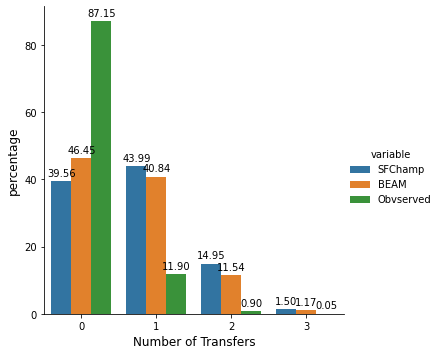

In [95]:
# get the number of transfers pic
df = dfBayAreaBeamEvents.get_ii_nTransfers()
dlast = df["numberofTransfers"].value_counts(sort=True,normalize=True).sort_index()*100
dfLast = dlast.rename_axis('noofTransfers').reset_index(name='counts')

df = dfBayAreaZerothEvents.get_ii_nTransfers()
dzero = df["numberofTransfers"].value_counts(sort=True,normalize=True).sort_index()*100
dfZero = dzero.rename_axis('noofTransfers').reset_index(name='counts')

# observed percentage values
d = {'noofTransfers': [0,1,2,3], 'LRT':[89.7, 9.7, 0.6, 0.0], "bus":[84.6,14.1,1.2,0.1]}
dfObserved = pd.DataFrame(data=d)
dfObserved["avg_pct"] = dfObserved[["LRT","bus"]].mean(axis=1)
dfObserved = dfObserved[["noofTransfers","avg_pct"]]
# dfObserved

#melt the dataframes
df = pd.merge(dfZero,dfLast, on='noofTransfers')
df = pd.merge(df,dfObserved,on="noofTransfers")

df.rename(columns={"counts_x":"SFChamp","counts_y":"BEAM","avg_pct":"Obvserved"},inplace=True)
df = pd.melt(df, id_vars="noofTransfers", value_vars=["SFChamp","BEAM","Obvserved"])
# df


# create bar plot
g = sns.catplot(x='noofTransfers', y='value', hue='variable', data=df, kind='bar')
plt.xlabel("Number of Transfers", fontsize = 12)
plt.ylabel("percentage", fontsize = 12)
# label the bar columns
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 8), textcoords = 'offset points')
# Iterate through the list of axes' patches
# for p in ax.patches:
#     ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
#             fontsize=10, color='red', ha='center', va='bottom')
# Saving the Seaborn Figure:
outfp = BASE_DIR.parent.joinpath("exported", f"Comparision -{simulation_run} -Number of Transfers.png")
# Saving the Seaborn Figure:
plt.savefig(outfp,dpi=300)

In [96]:
# dfLast = dfBayAreaBeamEvents.dfEvents
# dfFirst = dfBayAreaZerothEvents.dfEvents
#
# dfLast.loc[(~dfLast["person"].str.contains("ix",na=False)) & (~dfLast["person"].str.contains("rideHailAgent",na=False))
#            & (~dfLast["person"].str.contains("TransitDriverAgent",na=False)) & (~dfLast["person"].isna())
#            & (dfLast["type"]=="TripArrivalEvent"),"mode"].value_counts().sum()
#
# dfFirst.loc[(~dfFirst["person"].str.contains("ix",na=False)) & (~dfFirst["person"].str.contains("rideHailAgent",na=False))
#             & (~dfFirst["person"].str.contains("TransitDriverAgent",na=False)) & (~dfFirst["person"].isna())
#             & (dfFirst["type"]=="TripArrivalEvent"),"mode"].value_counts().sum()

In [97]:
# dData = dfBayAreaBeamEvents.get_ii_transfers_firstmile_summary()
# transfer_dict = (dData.groupby(["walkTransitDistances_cat","numberofTransfers_cat"]).size().reset_index().rename(columns={0: "count"}).groupby("walkTransitDistances_cat").apply(lambda mode_used: dict(zip(mode_used["numberofTransfers_cat"], mode_used["count"])))).copy()
# for key,values in transfer_dict.iteritems():
#     # print(key)
#     cat = ["0","1","2","3+"]
#     if isinstance(values,dict):
#         for k,v in transfer_dict.get(key).items():
#             print(k,"-->",v)
#             if k in cat:
#                 cat.remove(k)
#         for c in cat:
#             transfer_dict[key][c]=0
# # Populate noofTransfers by tourpurpose
# transfer_wrksheet = workbook["noTransfer_Summary"]
# for distance_cat,values in transfer_dict.iteritems():
#     if isinstance((values,dict)):
#         cell_row=11
#         cell_col="D"
#         for k,v in values.items():

In [98]:
# Lets export these values in csv format
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
# read the excel template
workbook = load_workbook(filename=BASE_DIR.parent.joinpath("template", "templatev11.0.xlsx"))
sheet = workbook["Summary"]

In [99]:
# Summary worksheet
# general information
iteration_counter = 1
cell_row=1
cell_column=1
sheet.cell(row=(cell_row),column=(cell_column+1)).value = ("BEAM Simulation iteration {}".format(iteration_counter))
# Folder
sheet.cell(row=(cell_row+1),column=(cell_column+1)).value = simulation_run
# Date
sheet.cell(row=(cell_row+2),column=(cell_column+1)).value ="{}".format(date_time)
# Notes
sheet.cell(row=(cell_row+3),column=(cell_column+1)).value = ""
#Sample information
# sample_pct = 0.05
sheet.cell(row=(cell_row+6),column=(cell_column+1)).value = sample_pct*100
sheet.cell(row=(cell_row+7),column=(cell_column+1)).value = 100/(100*sample_pct)
# scale_factor = 100/(100*sample_pct)

In [100]:
# Model Run - Last Iteration
# dump values for full Bay Area
#change the heading of the simulation run
#re-locate the fixed row and column = 11
cell_row=11
cell_column=6

temp = "Beam_Run_"+date_time
sheet.cell(row=(cell_row),column=(cell_column)).value = temp
# sheet.merge_cells('D2:E2')
# sheet["F2"].font = Font(b=True,size=10)

# VMT & VHT Data
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeam.VMT_sum
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeam.VHT_sum
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeam.VMT_VHT_ratio
# sheet["F9"] = (VHD_sum)

# Mode Share data
cell_row+=2
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["car_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare().get("car",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["transit_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value = (dfBayAreaBeamEvents.get_TT_modeshare().get("walk_transit",0) +
                                                         dfBayAreaBeamEvents.get_TT_modeshare().get("bike_transit",0) +
                                                         dfBayAreaBeamEvents.get_TT_modeshare().get("drive_transit",0) +
                                                         dfBayAreaBeamEvents.get_TT_modeshare().get("rideh_hail_transit",0))
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare()["walk_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare().get("walk",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare()["bike_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare().get("bike",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["ride_hail_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare().get("ride_hail",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare().get("ride_hail_pool",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare().get("hov2",0) + \
                                                       dfBayAreaBeamEvents.get_TT_modeshare().get("hov2_teleportation",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare().get("hov3",0) +\
                                                       dfBayAreaBeamEvents.get_TT_modeshare().get("hov3_teleportation",0)

# Boarding data
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=(dfBayAreaBeamEvents.TT_PTBoardings["bus_boarding"]*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.TT_PTBoardings["tram_boarding"]+dfBayAreaBeamEvents.TT_PTBoardings["cable_boarding"])*scale_factor
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.TT_PTBoardings["rail_boarding"]*scale_factor)

# Agent stats
cell_row+=3
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.get_agents_count()["ix_agents"]*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.get_agents_count()["ii_agents"]*scale_factor)
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.get_agents_count().get("ridehail_agent",0)*scale_factor)

# Unlinked trip information
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=  ((dfBayAreaBeamEvents.get_TT_unlinked_trips().get("car",0))*scale_factor)
# Transit
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("walk_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("drive_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("bike_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("ridehail_transit",0) *scale_factor)
# Pedestrian
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("walk",0)*scale_factor)
# Bike
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("bike",0)*scale_factor)
# Ridehail
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("ride_hail",0)*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("ride_hail_pooled",0)*scale_factor)
# HOV2 + HOV2_teleport
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("hov2",0)+
                                                         dfBayAreaBeamEvents.get_TT_unlinked_trips().get("hov2_teleportation",0))*scale_factor
# HOV3 + HOV3_teleport
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_unlinked_trips().get("hov3",0)+
                                                         dfBayAreaBeamEvents.get_TT_unlinked_trips().get("hov3_teleportation",0))*scale_factor

# "Total Trip Information"
cell_row+=3
sheet.cell(row=(cell_row),column=(cell_column)).value=  (sum(dfBayAreaBeamEvents.get_TT_unlinked_trips())*scale_factor)

# Auto ownership status
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_auto_ratio_status().get("no_auto",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_auto_ratio_status().get("auto_sufficient",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_auto_ratio_status().get("auto_deficient",0))

# Activity Type
cell_row+=2
# sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("home",0))
# cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("othmaint",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("escort",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("shopping",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("social",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("work",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("eatout",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("othdiscr",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("univ",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("school",0))

In [101]:
# SFChamp Run - First Iteration
# dump values for full Bay Area
#change the heading of the simulation run
#re-locate the fixed row and column = 11
cell_row=11
cell_column=9

temp = "SF_Champ_"+date_time
sheet.cell(row=(cell_row),column=(cell_column)).value = temp
# sheet.merge_cells('D2:E2')
# sheet["F2"].font = Font(b=True,size=10)

# Mode Share data
cell_row+=5
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["car_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaZerothEvents.get_TT_modeshare().get("car",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["transit_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value = (dfBayAreaZerothEvents.get_TT_modeshare().get("walk_transit",0) +
                                                         dfBayAreaZerothEvents.get_TT_modeshare().get("bike_transit",0) +
                                                         dfBayAreaZerothEvents.get_TT_modeshare().get("drive_transit",0) +
                                                         dfBayAreaZerothEvents.get_TT_modeshare().get("rideh_hail_transit",0))
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare()["walk_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_TT_modeshare().get("walk",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare()["bike_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_TT_modeshare().get("bike",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["ride_hail_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_TT_modeshare().get("ride_hail",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_TT_modeshare().get("ride_hail_pool",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_TT_modeshare().get("hov2",0) +\
                                                       dfBayAreaZerothEvents.get_TT_modeshare().get("hov2_teleportation",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_TT_modeshare().get("hov3",0) +\
                                                       dfBayAreaZerothEvents.get_TT_modeshare().get("hov3_teleportation",0)

# Boarding data
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=(dfBayAreaZerothEvents.TT_PTBoardings["bus_boarding"]*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.TT_PTBoardings["tram_boarding"]+
                                                        dfBayAreaZerothEvents.TT_PTBoardings["cable_boarding"])*scale_factor
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.TT_PTBoardings["rail_boarding"]*scale_factor)

# Agent stats
cell_row+=3
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.get_agents_count()["ix_agents"]*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.get_agents_count()["ii_agents"]*scale_factor)
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.get_agents_count().get("ridehail_agent",0)*scale_factor)

# Unlinked trip information
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=  ((dfBayAreaZerothEvents.get_TT_unlinked_trips().get("car",0))*scale_factor)
# Transit
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("walk_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("drive_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("bike_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("ridehail_transit",0) *scale_factor)
# Pedestrian
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("walk",0)*scale_factor)
# Bike
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("bike",0)*scale_factor)
# Ridehail
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("ride_hail",0)*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("ride_hail_pooled",0)*scale_factor)
# HOV2 + HOV2_teleport
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("hov2",0)+
                                                         dfBayAreaZerothEvents.get_TT_unlinked_trips().get("hov2_teleportation",0))*scale_factor
# HOV3 + HOV3_teleport
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_unlinked_trips().get("hov3",0)+
                                                         dfBayAreaZerothEvents.get_TT_unlinked_trips().get("hov3_teleportation",0))*scale_factor

# "Total Trip Information"
cell_row+=3
sheet.cell(row=(cell_row),column=(cell_column)).value=  (sum(dfBayAreaZerothEvents.get_TT_unlinked_trips())*scale_factor)

# Auto ownership status
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_auto_ratio_status().get("no_auto",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_auto_ratio_status().get("auto_sufficient",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_auto_ratio_status().get("auto_deficient",0))

# Activity Type
cell_row+=2
# sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("home",0))
# cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("othmaint",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("escort",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("shopping",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("social",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("work",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("eatout",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("othdiscr",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("univ",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_TT_activity_type().get("school",0))

In [102]:
# Model Run - Last Iteration
# dump values for SF County
#change the heading of the simulation run
#re-locate the fixed row and column = 11
cell_row=11
cell_column=16

temp = "Beam_Run_County_"+date_time
sheet.cell(row=(cell_row),column=(cell_column)).value = temp
# sheet.merge_cells('D2:E2')
# sheet["F2"].font = Font(b=True,size=10)

# VMT & VHT Data
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value = dfSFCountyBeam.VMT_sum
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value = dfSFCountyBeam.VHT_sum
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value = dfSFCountyBeam.VMT_VHT_ratio
# sheet["F9"] = (VHD_sum)

# Mode Share data
cell_row+=2
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["car_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_ii_modeshare().get("car",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["transit_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value = (dfBayAreaBeamEvents.get_ii_modeshare().get("walk_transit",0) +
                                                         dfBayAreaBeamEvents.get_ii_modeshare().get("bike_transit",0) +
                                                         dfBayAreaBeamEvents.get_ii_modeshare().get("drive_transit",0) +
                                                         dfBayAreaBeamEvents.get_ii_modeshare().get("rideh_hail_transit",0))
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare()["walk_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_ii_modeshare().get("walk",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare()["bike_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_ii_modeshare().get("bike",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["ride_hail_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_ii_modeshare().get("ride_hail",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_ii_modeshare().get("ride_hail_pool",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_ii_modeshare().get("hov2",0) +\
                                                       dfBayAreaBeamEvents.get_ii_modeshare().get("hov2_teleportation",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_ii_modeshare().get("hov3",0) +\
                                                       dfBayAreaBeamEvents.get_ii_modeshare().get("hov3_teleportation",0)

# Boarding data
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=(dfBayAreaBeamEvents.get_ii_PTBoardings().get("bus_boarding",0)*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.get_ii_PTBoardings().get("tram_boarding",0)+
                                                        dfBayAreaBeamEvents.get_ii_PTBoardings().get("cable_boarding",0))*scale_factor
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.get_ii_PTBoardings().get("rail_boarding",0)*scale_factor)

# Agent stats
cell_row+=3
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.get_agents_count()["ii_agents"]*scale_factor)
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaBeamEvents.get_agents_count().get("ridehail_agent",0)*scale_factor)

# Unlinked trip information
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=  ((dfBayAreaBeamEvents.get_ii_unlinked_trips().get("car",0))*scale_factor)
# Transit
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("walk_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("drive_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("bike_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("ridehail_transit",0) *scale_factor)
# Pedestrian
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("walk",0)*scale_factor)
# Bike
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("bike",0)*scale_factor)
# Ridehail
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("ride_hail",0)*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("ride_hail_pooled",0)*scale_factor)
# HOV2 + HOV2_teleport
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("hov2",0)+
                                                         dfBayAreaBeamEvents.get_ii_unlinked_trips().get("hov2_teleportation",0))*scale_factor
# HOV3 + HOV3_teleport
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_unlinked_trips().get("hov3",0)+
                                                         dfBayAreaBeamEvents.get_ii_unlinked_trips().get("hov3_teleportation",0))*scale_factor

# "Total Trip Information"
cell_row+=3
sheet.cell(row=(cell_row),column=(cell_column)).value=  (sum(dfBayAreaBeamEvents.get_ii_unlinked_trips())*scale_factor)

# Auto ownership status
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_auto_ratio_status().get("no_auto",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_auto_ratio_status().get("auto_sufficient",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_auto_ratio_status().get("auto_deficient",0))

# Activity Type
cell_row+=2
# sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("home",0))
# cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("othmaint",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("escort",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("shopping",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("social",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("work",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("eatout",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("othdiscr",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("univ",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_ii_activity_type().get("school",0))

C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [103]:
# SF Champ - First Iteration
# dump values for SF County
#change the heading of the simulation run
#re-locate the fixed row and column = 11
cell_row=11
cell_column=19

temp = "SF_Champ_County_"+date_time
sheet.cell(row=(cell_row),column=(cell_column)).value = temp
# sheet.merge_cells('D2:E2')
# sheet["F2"].font = Font(b=True,size=10)

# VMT & VHT Data
# cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfSFCountyBeam.VMT_sum
# cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfSFCountyBeam.VHT_sum
# cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfSFCountyBeam.VMT_VHT_ratio
# sheet["F9"] = (VHD_sum)

# Mode Share data
cell_row+=5
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["car_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaZerothEvents.get_ii_modeshare().get("car",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["transit_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value = (dfBayAreaZerothEvents.get_ii_modeshare().get("walk_transit",0) +
                                                         dfBayAreaZerothEvents.get_ii_modeshare().get("bike_transit",0) +
                                                         dfBayAreaZerothEvents.get_ii_modeshare().get("drive_transit",0) +
                                                         dfBayAreaZerothEvents.get_ii_modeshare().get("rideh_hail_transit",0))
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare()["walk_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_ii_modeshare().get("walk",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaBeamEvents.get_TT_modeshare()["bike_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_ii_modeshare().get("bike",0)
cell_row+=1
# sheet.cell(row=(cell_row),column=(cell_column)).value = dfBayAreaBeamEvents.get_TT_modeshare()["ride_hail_share"]
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_ii_modeshare().get("ride_hail",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_ii_modeshare().get("ride_hail_pool",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_ii_modeshare().get("hov2",0) +\
                                                       dfBayAreaZerothEvents.get_ii_modeshare().get("hov2_teleportation",0)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= dfBayAreaZerothEvents.get_ii_modeshare().get("hov3",0) +\
                                                       dfBayAreaZerothEvents.get_ii_modeshare().get("hov3_teleportation",0)

# Boarding data
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=(dfBayAreaZerothEvents.get_ii_PTBoardings().get("bus_boarding",0)*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.get_ii_PTBoardings().get("tram_boarding",0)+
                                                        dfBayAreaZerothEvents.get_ii_PTBoardings().get("cable_boarding",0))*scale_factor
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.get_ii_PTBoardings().get("rail_boarding",0)*scale_factor)

# Agent stats
cell_row+=3
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.get_agents_count()["ii_agents"]*scale_factor)
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value= (dfBayAreaZerothEvents.get_agents_count().get("ridehail_agent",0)*scale_factor)

# Unlinked trip information
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=  ((dfBayAreaZerothEvents.get_ii_unlinked_trips().get("car",0))*scale_factor)
# Transit
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("walk_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("drive_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("bike_transit",0) *scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("ridehail_transit",0) *scale_factor)
# Pedestrian
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("walk",0)*scale_factor)
# Bike
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("bike",0)*scale_factor)
# Ridehail
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("ride_hail",0)*scale_factor)
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("ride_hail_pooled",0)*scale_factor)
# HOV2 + HOV2_teleport
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("hov2",0)+
                                                         dfBayAreaZerothEvents.get_ii_unlinked_trips().get("hov2_teleportation",0))*scale_factor
# HOV3 + HOV3_teleport
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_unlinked_trips().get("hov3",0)+
                                                         dfBayAreaZerothEvents.get_ii_unlinked_trips().get("hov3_teleportation",0))*scale_factor

# "Total Trip Information"
cell_row+=3
sheet.cell(row=(cell_row),column=(cell_column)).value=  (sum(dfBayAreaZerothEvents.get_ii_unlinked_trips())*scale_factor)

# Auto ownership status
cell_row+=2
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_auto_ratio_status().get("no_auto",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_auto_ratio_status().get("auto_sufficient",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_auto_ratio_status().get("auto_deficient",0))

# Activity Type
cell_row+=2
# sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaBeamEvents.get_TT_activity_type().get("home",0))
# cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("othmaint",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("escort",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("shopping",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("social",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("work",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("eatout",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("othdiscr",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("univ",0))
cell_row+=1
sheet.cell(row=(cell_row),column=(cell_column)).value=  (dfBayAreaZerothEvents.get_ii_activity_type().get("school",0))

C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [104]:
# Lets export these values in csv format
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment

# read the excel template
# workbook = load_workbook(filename=BASE_DIR.parent.joinpath("template", "templatev7.0.xlsx"))
Mode_Choice_wrksheet = workbook["Mode_Choice"]

def nested_dict_pairs_populator(dict_obj,row_no,col_no):
    # Mode_Choice_wrksheet = sorted(dict_obj.items(),key=lambda kv:kv[1])
    modechoice_summary = OrderedDict(sorted(dict_obj.items())).copy()
    cell_row=row_no
    cell_column=col_no
    for mode, count in modechoice_summary.items():
        if "bike" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "bike_transit" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "car" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "drive_transit" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "hov2" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "hov2_teleportation" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "hov3" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "hov3_teleportation" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "ride_hail" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "ride_hail_pooled" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "ride_hail_transit" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "walk" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        elif "walk_transit" in mode:
            Mode_Choice_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
            cell_column+=1
        else:
            continue
modechoice_summary = dfBayAreaBeamEvents.get_ii_tourpurpose_stats()
for tour_purpose in modechoice_summary.keys():
    if "work" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =11
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "school" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =29
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "univ" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =47
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "shopping" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =65
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "othmaint" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =83
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "eatout" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =101
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "social" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =119
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "othdiscr" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =137
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "escort" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =155
            if "no_auto" in auto_ownership:
                cell_row="D"
            elif "auto_deficient" in auto_ownership:
                cell_row="E"
            elif "auto_sufficient" in auto_ownership:
                cell_row="F"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)

modechoice_summary = dfBayAreaZerothEvents.get_ii_tourpurpose_stats()
for tour_purpose in modechoice_summary.keys():
    if "work" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =11
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "school" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =29
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "univ" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =47
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "shopping" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =65
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "othmaint" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =83
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "eatout" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =101
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "social" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =119
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "othdiscr" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =137
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)
    elif "escort" in tour_purpose:
        for auto_ownership in modechoice_summary[tour_purpose].keys():
            cell_column =155
            if "no_auto" in auto_ownership:
                cell_row="L"
            elif "auto_deficient" in auto_ownership:
                cell_row="M"
            elif "auto_sufficient" in auto_ownership:
                cell_row="N"
            nested_dict_pairs_populator(modechoice_summary[tour_purpose][auto_ownership],cell_row,cell_column)

In [105]:
# Populate noofTransfers summary
transfer_dict = dfBayAreaBeamEvents.get_ii_transfers_firstmile_summary()
transfer_wrksheet = workbook["noTransfer_Summary"]
for distance_cat,values in transfer_dict.iteritems():
    if isinstance(values,dict):
        if distance_cat=="<=0.25mil":
            cell_row=11
            cell_col=4
        elif distance_cat==">0.25mil & <=0.5mil":
            cell_row=12
            cell_col=4
        elif distance_cat==">0.5mil & <=0.75mil":
            cell_row=13
            cell_col=4
        elif distance_cat==">0.75mil & <=1mil":
            cell_row=14
            cell_col=4
        elif distance_cat==">1mil":
            cell_row=15
            cell_col=4
        for k,v in transfer_dict.get(distance_cat).items():
            transfer_wrksheet.cell(row=(cell_row),column=(cell_col)).value=round((v)*scale_factor)
            cell_col+=1

transfer_dict = dfBayAreaZerothEvents.get_ii_transfers_firstmile_summary()
for distance_cat,values in transfer_dict.iteritems():
    if isinstance(values,dict):
        if distance_cat=="<=0.25mil":
            cell_row=11
            cell_col=14
        elif distance_cat==">0.25mil & <=0.5mil":
            cell_row=12
            cell_col=14
        elif distance_cat==">0.5mil & <=0.75mil":
            cell_row=13
            cell_col=14
        elif distance_cat==">0.75mil & <=1mil":
            cell_row=14
            cell_col=14
        elif distance_cat==">1mil":
            cell_row=15
            cell_col=14
        for k,v in transfer_dict.get(distance_cat).items():
            transfer_wrksheet.cell(row=(cell_row),column=(cell_col)).value=round((v)*scale_factor)
            cell_col+=1

C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [106]:
transfer_summary = dfBayAreaBeamEvents.get_ii_transfers()
transfer_summary

C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

tourPurpose
eatout      {'0': {'<=0.25mil': 230, '>0.25mil & <=0.5mil'...
escort      {'0': {'<=0.25mil': 150, '>0.25mil & <=0.5mil'...
othdiscr    {'0': {'<=0.25mil': 27, '>0.25mil & <=0.5mil':...
othmaint    {'0': {'<=0.25mil': 281, '>0.25mil & <=0.5mil'...
school      {'0': {'<=0.25mil': 87, '>0.25mil & <=0.5mil':...
shopping    {'0': {'<=0.25mil': 267, '>0.25mil & <=0.5mil'...
social      {'0': {'<=0.25mil': 205, '>0.25mil & <=0.5mil'...
univ        {'0': {'<=0.25mil': 100, '>0.25mil & <=0.5mil'...
work        {'0': {'<=0.25mil': 868, '>0.25mil & <=0.5mil'...
dtype: object

In [107]:
# Populate noofTransfers by tourpurpose
transfer_wrksheet = workbook["noofTransfers_tourpurpose"]

def nested_dict_pairs_populator(dict_obj,row_no,col_no):
    # Mode_Choice_wrksheet = sorted(dict_obj.items(),key=lambda kv:kv[1])
    transfer_summary = OrderedDict(sorted(dict_obj.items())).copy()
    cell_row=row_no
    cell_column=col_no
    for mode, count in transfer_summary.items():
        if "<=0.25mil" in mode:
            transfer_wrksheet["{}{}".format(cell_row,cell_column)].value=round(int(count)*scale_factor)
            cell_column+=1
        elif ">0.25mil & <=0.5mil" in mode:
            transfer_wrksheet["{}{}".format(cell_row,cell_column)].value=round(int(count)*scale_factor)
            cell_column+=1
        elif ">0.5mil & <=0.75mil" in mode:
            transfer_wrksheet["{}{}".format(cell_row,cell_column)].value=round(int(count)*scale_factor)
            cell_column+=1
        elif ">0.75mil & <=1mil" in mode:
            transfer_wrksheet["{}{}".format(cell_row,cell_column)].value=round(int(count)*scale_factor)
            cell_column+=1
        elif ">1mil" in mode:
            transfer_wrksheet["{}{}".format(cell_row,cell_column)].value=round(int(count)*scale_factor)
            cell_column+=1
        else:
            continue
# Last iteration - Event
transfer_summary = dfBayAreaBeamEvents.get_ii_transfers()
for tour_purpose in transfer_summary.keys():
    if "work" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =11
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "school" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =21
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "univ" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =31
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "shopping" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =41
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "othmaint" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =51
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "eatout" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =61
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "social" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =71
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "othdiscr" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =81
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "escort" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =91
            if "0" in transfr:
                cell_row="D"
            elif "1" in transfr:
                cell_row="E"
            elif "2" in transfr:
                cell_row="F"
            elif "3+" in transfr:
                cell_row="G"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)

# First iteration - Event
transfer_summary = dfBayAreaZerothEvents.get_ii_transfers()
for tour_purpose in transfer_summary.keys():
    if "work" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =11
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "school" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =21
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "univ" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =31
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "shopping" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =41
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "othmaint" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =51
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "eatout" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =61
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "social" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =71
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "othdiscr" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =81
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)
    elif "escort" in tour_purpose:
        for transfr in transfer_summary.get(tour_purpose).keys():
            cell_column =91
            if "0" in transfr:
                cell_row="N"
            elif "1" in transfr:
                cell_row="O"
            elif "2" in transfr:
                cell_row="P"
            elif "3+" in transfr:
                cell_row="Q"
            nested_dict_pairs_populator(transfer_summary[tour_purpose][transfr],cell_row,cell_column)

C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Goyal\AppData\Local\Temp\ipykernel_7176\3936115848.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [108]:
# save the data
workbook.save(BASE_DIR.parent.joinpath("exported", f"Summary_report_{simulation_run}_v11.0.xlsx"))

In [ ]:
# save the data
# workbook.save(BASE_DIR.parent.joinpath("exported", "summary_report_v10.0_trial.xlsx"))

In [ ]:
# def nested_dict_pairs_populator(dict_obj,row_no,col_no):
#     # Mode_Choice_wrksheet = sorted(dict_obj.items(),key=lambda kv:kv[1])
#     transfer_summary = OrderedDict(sorted(dict_obj.items())).copy()
#     cell_row=row_no
#     cell_column=col_no
#     for mode, count in transfer_summary.items():
#         if "<0.25mil" in mode:
#             transfer_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
#         elif ">=0.25mil & <0.5mil" in mode:
#             cell_column+=1
#             transfer_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
#         elif ">=0.5mil & <1mil" in mode:
#             cell_column+=1
#             transfer_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
#         elif ">=1mil" in mode:
#             cell_column+=1
#             transfer_wrksheet["{}{}".format(cell_row,cell_column)]=count*scale_factor
#         else:
#             continue
# Populate noofTransfers by tourpurpose
# transfer_wrksheet = workbook["noTransfer_Summary"]
# #Last iteration - Event
# transfer_summary = dfBayAreaBeamEvents.get_ii_transfers_firstmile_summary()
# cell_column=11
# cell_row="D"
# nested_dict_pairs_populator(transfer_summary,cell_row,cell_column)

In [ ]:
# df = dfBayAreaBeamEvents.dfEvents
# df = df[~df["person"].str.contains("ix",na=False) & ~df["person"].str.contains("rideHailAgent",na=False) & ~df["person"].str.contains("TransitDriverAgent",na=False) & (~df["person"].isna())].copy()
# df.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:]
# df = df.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:]
# df["walkTransitDistances"]= df["tracingData"].str.rsplit(":",3)
# df["trip_cost_utility"]= df["tracingData"].str.rsplit(":",2)[1]
# df["numberofTransfers"]= df["tracingData"].str[-22:].str.split(")",expand=True)[0]

# df["walkTransitDistances"]= df["tracingData"].str.rsplit(":",expand=True)[3]
# df["trip_cost_utility"]= df["tracingData"].str.rsplit(":",expand=True)[1]
# df["numberofTransfers"]= df["tracingData"].str.rsplit(":",expand=True)[0]

# df["walkTransitDistances"]= df["tracingData"].str.split(":",expand=True)[0].str.split(",",expand=True)[1].str.split(")",expand=True)[0]
# df["trip_cost_utility"]= df["tracingData"].str.split(":",expand=True)[1].str.split(",",expand=True)[1].str.split(")",expand=True)[0]
# df["numberofTransfers"]= df["tracingData"].str.split(":",expand=True)[2].str.split(",",expand=True)[1].str.split(")",expand=True)[0]
#
# df["walkTransitDistances"] = pd.to_numeric(df["walkTransitDistances"], errors='coerce').replace(np.nan,0,regex=True)
# df["trip_cost_utility"] = pd.to_numeric(df["trip_cost_utility"], errors='coerce').replace(np.nan,0,regex=True)
# df["numberofTransfers"] = pd.to_numeric(df["numberofTransfers"], errors='coerce').replace(np.nan,0,regex=True).round(0).astype(int)

# dData = df.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:][["tracingData","walkTransitDistances","trip_cost_utility","numberofTransfers"]]
# df.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:][["tracingData","walkTransitDistances","trip_cost_utility","numberofTransfers"]]

# df["numberofTransfers"]=df["tracingData"].str[-22:].str.split(")",expand=True)[0]
# df["travel_cost"]= df["tracingData"].str[-34:-25]

In [ ]:
# df["noofTransfers"]=df.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:]["tracingData"].str[-22:].str.split(")",expand=True)[0].str.split(",",expand=True)[1]
# df["travelCosts"]=df.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:]["tracingData"].str[-34:-25].str.split(",",expand=True)[1]
# df["walkTransitDistance"] = df.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:]["tracingData"].str[1:-37].str.split(",",expand=True)[1].str.split(":",expand=True)[0]
# df.loc[(df["type"]=="ModeChoice") & (df["mode"]=="walk_transit"),:][["tracingData","walkTransitDistance","travelCosts","noofTransfers"]]

In [ ]:
# dfLast = dfBayAreaBeamEvents.dfEvents
# dfFirst = dfBayAreaZerothEvents.dfEvents

In [ ]:
# dfLast.loc[(~dfLast["person"].str.contains("ix",na=False)) & (~dfLast["person"].str.contains("rideHailAgent",na=False))
#            & (~dfLast["person"].str.contains("TransitDriverAgent",na=False)) & (~dfLast["person"].isna())
#            & (dfLast["type"]=="TripArrivalEvent"),"mode"].value_counts().sum()*20

In [ ]:
# dfFirst.loc[(~dfFirst["person"].str.contains("ix",na=False)) & (~dfFirst["person"].str.contains("rideHailAgent",na=False))
#             & (~dfFirst["person"].str.contains("TransitDriverAgent",na=False)) & (~dfFirst["person"].isna())
#             & (dfFirst["type"]=="TripArrivalEvent"),"mode"].value_counts().sum()*20

In [ ]:
# df2 = dfLast.loc[(~dfLast["person"].str.contains("ix",na=False)) & (~dfLast["person"].str.contains("rideHailAgent",na=False))
#            & (~dfLast["person"].str.contains("TransitDriverAgent",na=False)) & (~dfLast["person"].isna())
#            & (dfLast["type"]=="TripArrivalEvent"),]
#
# df1 = dfFirst.loc[(~dfFirst["person"].str.contains("ix",na=False)) & (~dfFirst["person"].str.contains("rideHailAgent",na=False))
#             & (~dfFirst["person"].str.contains("TransitDriverAgent",na=False)) & (~dfFirst["person"].isna())
#             & (dfFirst["type"]=="TripArrivalEvent"),]
#
# df3 = pd.concat([df1,df2]).drop_duplicates(keep=False)
#
# df4 = pd.concat([df2,df1]).drop_duplicates(keep=False)

In [ ]:
# df2.to_csv(BASE_DIR.parent.joinpath("exported", "Last_iteration.10_trial.csv"))
# df1.to_csv(BASE_DIR.parent.joinpath("exported", "First_iteration.10_trial.csv"))

In [ ]:
# tour_purpose_dict = dfTour.groupby(["tourPurpose", "vehicleOwnership", "mode"]).size().reset_index().rename(columns={0: "count"})\
#                           .groupby("tourPurpose")\
#                           .apply(lambda vehOwntype: dict(vehOwntype.groupby("vehicleOwnership")
#                                                          .apply(lambda mode_used: dict(zip(mode_used["mode"], mode_used["count"]))))).copy()

In [ ]:
# dfEvents = self.dfEvents.copy()
# dfTour = dfEvents.loc[(~dfEvents["person"].str.contains("ix",na=False) &
#                        ~dfEvents["person"].str.contains("rideHailAgent",na=False) &
#                        ~dfEvents["person"].str.contains("TransitDriverAgent",na=False) &
#                        (~dfEvents["person"].isna())),:]
#     .dropna(subset = ["vehicleOwnership"])
# dfTour=dfTour[dfTour["type"]=="TripArrivalEvent"]
# tour_purpose_dict = dfTour.groupby(["tourPurpose", "vehicleOwnership", "mode"]).size().reset_index().rename(columns={0: "count"})
#     .groupby("tourPurpose")
#     .apply(lambda vehOwntype: dict(vehOwntype.groupby("vehicleOwnership")
#                                    .apply(lambda mode_used: dict(zip(mode_used["mode"], mode_used["count"]))))).copy()
# for key,value in tour_purpose_dict.iteritems():
#     if isinstance(tour_purpose_dict.get(key),dict):
#         for auto_ownership,modes in tour_purpose_dict.get(key).items():
#             mode_keys = ["car", "walk_transit", "drive_transit", "bike_transit", "ride_hail_transit", "walk", "bike", "ride_hail_pooled", "ride_hail", "hov2_teleportation", "hov2","hov3_teleportation", "hov3"]
#             if isinstance(modes,dict):
#                 for mode,count in modes.items():
#                     if mode in mode_keys:
#                         mode_keys.remove(mode)
#                 for mode in mode_keys:
#                     tour_purpose_dict[key][auto_ownership][mode]=0

In [ ]:
# (dfLast.loc[(~dfLast["person"].str.contains("ix",na=False)) & (~dfLast["person"].str.contains("rideHailAgent",na=False))
#             & (~dfLast["person"].str.contains("TransitDriverAgent",na=False)) & (~dfLast["person"].isna())
#             & (dfLast["type"]=="TripArrivalEvent"),].groupby(["tourPurpose", "vehicleOwnership", "mode"]).size())

In [ ]:
# df2.groupby(["tourPurpose", "vehicleOwnership", "mode"]).size().reset_index().rename(columns={0: "count"})
# (dfLast.loc[(~dfLast["person"].str.contains("ix",na=False)) & (~dfLast["person"].str.contains("rideHailAgent",na=False))
#            & (~dfLast["person"].str.contains("TransitDriverAgent",na=False)) & (~dfLast["person"].isna())
#            & (dfLast["type"]=="TripArrivalEvent"),].groupby(["tourPurpose", "vehicleOwnership", "mode"]).size()*20).to_csv(BASE_DIR.parent.joinpath("exported", "Last_iteration_tour.10_trial.csv"))
# df2.groupby(["tourPurpose", "vehicleOwnership", "mode"]).size()*20

In [ ]:
# (dfFirst.loc[(~dfFirst["person"].str.contains("ix",na=False)) & (~dfFirst["person"].str.contains("rideHailAgent",na=False))
#             & (~dfFirst["person"].str.contains("TransitDriverAgent",na=False)) & (~dfFirst["person"].isna())
#             & (dfFirst["type"]=="TripArrivalEvent"),].groupby(["tourPurpose", "vehicleOwnership", "mode"]).size()*20).to_csv(BASE_DIR.parent.joinpath("exported", "First_iteration_tour.10_trial.csv"))

In [ ]:
# pd.DataFrame(dfBayAreaZerothEvents.get_ii_tourpurpose_stats()).to_csv(BASE_DIR.parent.joinpath("exported", "First_iteration_tour_aftr.10_trial.csv"))
# pd.DataFrame(dfBayAreaBeamEvents.get_ii_tourpurpose_stats()).to_csv(BASE_DIR.parent.joinpath("exported", "Last_iteration_tour_aftr.10_trial.csv"))

In [9]:
# Read the linkstats file
dfLink = pd.read_csv((BASE_DIR.parent.joinpath("runs",simulation_run,"ITERS",("it."+str(last_iter)),(str(last_iter)+".linkstats.csv.gz"))))
links = dfLink[["link","length"]]
links = links.drop_duplicates()
# create a dictionary linkId vs length_of_links
ulinks = dict(zip(links["link"],links["length"]))
# Read the physim events file
dfphysim = pd.read_csv((BASE_DIR.parent.joinpath("runs",simulation_run,"ITERS",("it."+str(last_iter)),(str(last_iter)+".physSimEvents.csv.gz"))))
dfphysim_2 = dfphysim.loc[(dfphysim["type"]=="entered link")]
# dfphysim_2 = dfphysim_2.loc[~dfphysim_2["vehicle"].str.contains("BA|SF", na=False),:]
# replace the length which is mostly "0" in the "entered link" with the actual link length
dfphysim_2["length"] = dfphysim_2["link"].map(ulinks)
dfphysim_2["volume"]=1 #include a

_df = dfphysim_2.groupby(["link"]).size().reset_index().rename(columns={0:"count"})
_df["length"] = _df["link"].map(ulinks)
_df.to_csv(BASE_DIR.parent.joinpath("exported", "Last_iteration_physim.csv"))

dfLink.groupby(["link"]).agg({"length":"first","volume":"sum", "capacity":"sum"}).reset_index().to_csv(BASE_DIR.parent.joinpath("exported", "Last_iteration_linkstats.csv"))

c:\users\goyal\.virtualenvs\t-score-0msqhlpo\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [7]:
dfLink.loc[dfLink["link"]==93642,"volume"].sum()

253.0

In [6]:
_df[_df["link"]==93642]

,link,count,length
29388,93642,253,883.811


In [112]:
physim = dfphysim_2.groupby(["link"]).size().reset_index().rename(columns={0:"count"})
linkstat = dfLink.groupby(["link"]).agg({"length":"first","volume":"sum"})

In [100]:
dfphysim.loc[(dfphysim["type"]=="entered link")]["link"].nunique()

30229

In [110]:
linkstat = dfLink.groupby(["link"]).agg({"length":"first","volume":"sum"})

,length,volume
link,,
0,244.148,324.0
1,244.148,0.0
2,167.183,12.0
3,167.183,0.0
4,186.697,0.0
...,...,...
97195,8.067,0.0
97196,93.880,2.0
97197,93.880,0.0


In [115]:
dfjoin = pd.merge(linkstat,physim, on="link")
dfjoin.to_csv(BASE_DIR.parent.joinpath("exported", "Joined_Last_iteration.csv"))

In [116]:
dfjoin_2 = dfjoin[dfjoin["link"].isin(network_links.keys())]

In [121]:
# ### now read the link stat from the SF County
# gdSFCountyNetwork = gpd.read_file((BASE_DIR.parent.joinpath("runs", simulation_run,"Network","SFCounty_EPSG4326.geojson")),driver='GeoJSON')
# gdfSFBoundary = gpd.read_file((BASE_DIR.parent.joinpath("runs", simulation_run,"Network","SFCounty_boundary_EPSG4326.geojson")),driver='GeoJSON')
#
# df = gdSFCountyNetwork.loc[~gdSFCountyNetwork["Information"].isin(['San Mateo', 'Golden Gate Bridge', 'SFOak1', 'SFOak2'])]
# # # convert it to dictinary "Length" & "Link"
# network_links = dict(zip(df["ID"], df["LENGTH"]))
#
# dfBayArea = pd.read_csv(BASE_DIR.parent.joinpath((BASE_DIR.parent.joinpath("runs",simulation_run,"ITERS",("it."+str(last_iter)),(str(last_iter)+".linkstats.csv.gz")))), compression="gzip", low_memory=True)
# dfBayArea.reset_index(drop=True,inplace=True)
# dfBayArea["link"]=dfBayArea["link"].astype(str)
# dfSFCounty=dfBayArea[dfBayArea["link"].isin(network_links.keys())]
# dfSFCountyBeam = linkstats_to_df(dfSFCounty)

In [117]:
dfjoin_2

,link,length,volume,count


In [119]:
# physim[physim["link"].isin(network_links.keys())]

,link,count


In [130]:
df

,ID,FROM,TO,LENGTH,CAPACITY,LANES,MODES,FRSPEED,Information,geometry
0,24746,6090,6228,104.832,650.0,1.0,"car,walk,bike",6.21,None,"MULTILINESTRING ((-122.39897 37.79428, -122.40..."
1,24846,6266,6264,30.571,2550.0,3.0,"car,walk,bike",6.21,None,"MULTILINESTRING ((-122.40272 37.79093, -122.40..."
2,10446,2648,2656,74.760,300.0,1.0,"car,walk,bike",7.45,None,"MULTILINESTRING ((-122.43462 37.74322, -122.43..."
3,91215,10995,21271,19.361,700.0,1.0,"walk,bike",7.45,None,"MULTILINESTRING ((-122.38312 37.74388, -122.38..."
4,40839,9782,9787,208.259,300.0,1.0,"walk,bike",7.45,None,"MULTILINESTRING ((-122.46977 37.78270, -122.46..."
...,...,...,...,...,...,...,...,...,...,...
66555,94351,8940,8943,138.244,300.0,1.0,"walk,bike",6.21,None,"MULTILINESTRING ((-122.43859 37.79574, -122.43..."
66556,12405,2973,2969,199.006,350.0,1.0,"walk,bike",7.45,None,"MULTILINESTRING ((-122.45116 37.73306, -122.45..."
66557,45656,53,11007,124.976,350.0,1.0,"car,walk,bike",7.45,None,"MULTILINESTRING ((-122.37316 37.72864, -122.37..."
66558,20057,4922,4968,142.139,300.0,1.0,"walk,bike",7.45,None,"MULTILINESTRING ((-122.39918 37.75985, -122.39..."
